In [139]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras import callbacks
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

In [140]:
tf.__version__

'2.16.1'

In [141]:
keras.__version__


'3.3.3'

In [142]:
df=pd.read_csv('train.csv')


In [143]:
df.shape

(42000, 785)

In [144]:
x = df.iloc[:,1:].values
y = df['label'].values

In [145]:
x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [146]:
x.shape


(42000, 784)

In [147]:
y.shape

(42000,)

In [148]:
y

array([1, 0, 1, ..., 7, 6, 9], dtype=int64)

In [149]:
demo=x[900]
demo=demo.reshape(28,28)

In [150]:
x.dtype

dtype('int64')

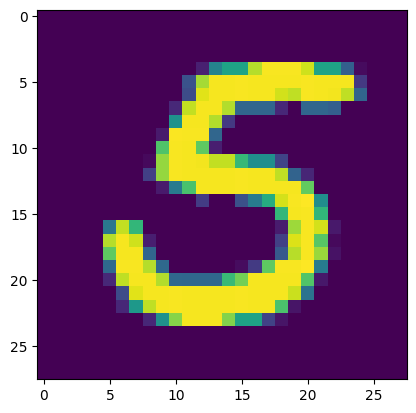

In [151]:
plt.imshow(demo, interpolation = 'nearest')


In [152]:
y[800]

5

In [153]:
X = x.reshape(-1, 28, 28)

In [154]:
# Resize each image to (64, 64) using TensorFlow
X_resized = tf.image.resize(X[..., np.newaxis], [64, 64]).numpy()
X_resized = X_resized.squeeze()  # Remove the unnecessary channel dimension

In [155]:
print("Data shape after resizing:", X_resized.shape)

Data shape after resizing: (42000, 64, 64)


In [156]:
# X_flattened = X_resized.reshape(-1, 64 * 64)

In [157]:
X_train, X_test, Y_train, Y_test= train_test_split(X_resized,y, test_size=0.15, random_state=42)


In [158]:
# Further split training data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.15, random_state=42)


In [159]:

# Print the shapes to verify they are consistent
print("X_train shape:", X_train.shape)  # Training set shape (should be (number of samples, 64, 64))
print("y_train shape:", y_train.shape)
print("X_valid shape:", X_valid.shape)  # Validation set shape (should be (number of samples, 64, 64))
print("y_valid shape:", y_valid.shape)
print("X_test shape:", X_test.shape)    # Test set shape (should be (number of samples, 64, 64))
print("y_test shape:", Y_test.shape)

X_train shape: (30345, 64, 64)
y_train shape: (30345,)
X_valid shape: (5355, 64, 64)
y_valid shape: (5355,)
X_test shape: (6300, 64, 64)
y_test shape: (6300,)


In [160]:
# Reshape the first training sample for visualization
sample_image = X_train[0].reshape(64, 64)

In [161]:
X_train.dtype

dtype('float32')

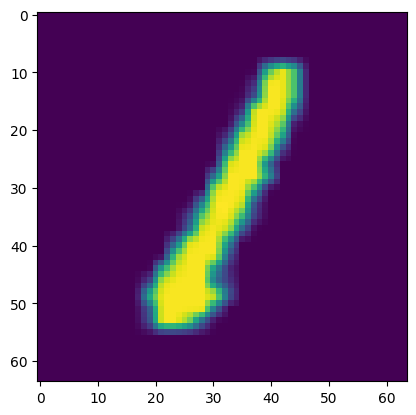

In [162]:
plt.imshow(sample_image, interpolation = 'nearest')


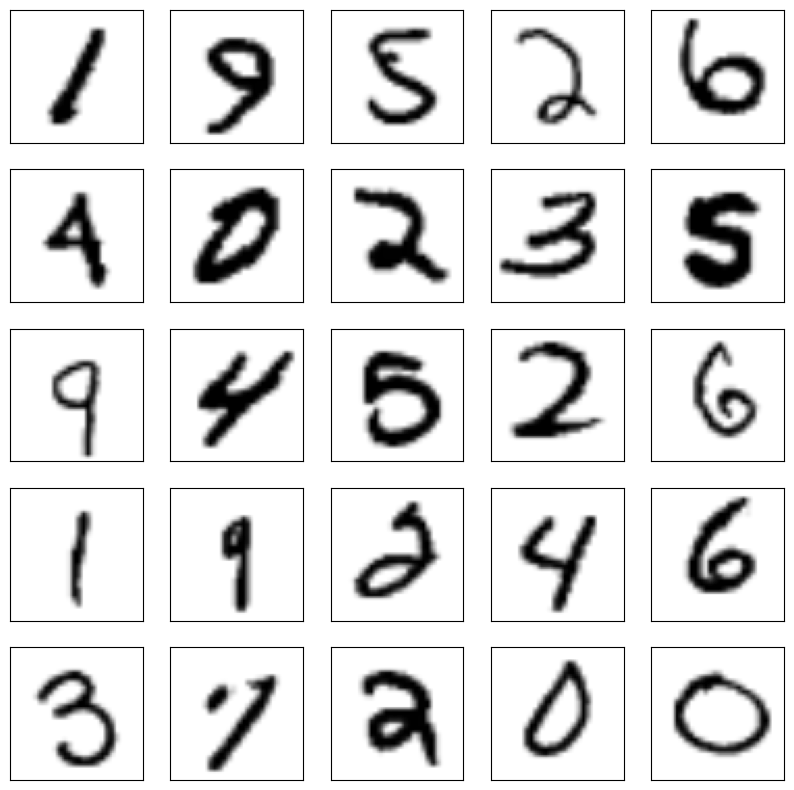

In [163]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape(64, 64),cmap=plt.cm.binary)
plt.show()

In [164]:

print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",Y_train.shape)
print("y test: ",Y_test.shape)

x train:  (30345, 64, 64)
x test:  (6300, 64, 64)
y train:  (35700,)
y test:  (6300,)


In [165]:
from functools import partial
DConv2D=partial(keras.layers.Conv2D,kernel_size=3,activation='relu',padding='SAME')

In [167]:
model = keras.models.Sequential([
    DConv2D(filters=32,kernel_size=7,input_shape=[64,64,1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DConv2D(filters=64),
    DConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2),
    DConv2D(filters=128),
    DConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),  
    keras.layers.Dense(
        64, 
        activation='relu', 
    ),
    keras.layers.Dropout(rate=0.5), 
    keras.layers.Dense(
        32, 
        activation='relu', 
    ),
    keras.layers.Dropout(rate=0.5), 
    keras.layers.Dense(
        10, 
        activation='softmax' 
    )
])


c:\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [168]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 32)     │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 805,226 (3.07 MB)

 Trainable params: 805,226 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

In [169]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer='sgd',
              metrics=['accuracy'])


In [170]:
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid))


Epoch 1/15
949/949 ━━━━━━━━━━━━━━━━━━━━ 66s 69ms/step - accuracy: 0.3255 - loss: 2.1191 - val_accuracy: 0.5010 - val_loss: 2.1098
Epoch 2/15
949/949 ━━━━━━━━━━━━━━━━━━━━ 65s 68ms/step - accuracy: 0.6482 - loss: 1.0523 - val_accuracy: 0.9619 - val_loss: 0.2334
Epoch 3/15
949/949 ━━━━━━━━━━━━━━━━━━━━ 65s 68ms/step - accuracy: 0.7385 - loss: 0.7657 - val_accuracy: 0.9727 - val_loss: 0.1827
Epoch 4/15
949/949 ━━━━━━━━━━━━━━━━━━━━ 64s 67ms/step - accuracy: 0.7845 - loss: 0.6378 - val_accuracy: 0.9742 - val_loss: 0.1348
Epoch 5/15
949/949 ━━━━━━━━━━━━━━━━━━━━ 64s 67ms/step - accuracy: 0.8094 - loss: 0.5864 - val_accuracy: 0.9815 - val_loss: 0.1005
Epoch 6/15
949/949 ━━━━━━━━━━━━━━━━━━━━ 63s 67ms/step - accuracy: 0.8418 - loss: 0.5001 - val_accuracy: 0.9516 - val_loss: 0.3435
Epoch 7/15
949/949 ━━━━━━━━━━━━━━━━━━━━ 64s 68ms/step - accuracy: 0.8713 - loss: 0.4197 - val_accuracy: 0.9836 - val_loss: 0.0853
Epoch 8/15
949/949 ━━━━━━━━━━━━━━━━━━━━ 65s 69ms/step - accuracy: 0.8852 - loss: 0.3684 - 

In [171]:
test_loss,test_acc=model.evaluate(X_valid,y_valid,verbose=2)

168/168 - 3s - 21ms/step - accuracy: 0.9767 - loss: 0.1370


In [172]:
print('accuracy',test_acc)

accuracy 0.9766573309898376


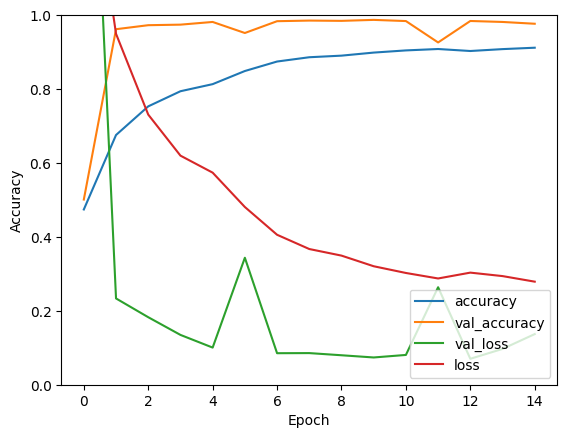

In [173]:
# Plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [174]:
model.save(r"C:\Users\sondo\OneDrive - Faculty of Computer and Information Sciences (Ain Shams University)\Desktop\tasks\task7\model.h5", save_format='h5')


In [176]:
model=tf.keras.models.load_model(r"C:\Users\sondo\OneDrive - Faculty of Computer and Information Sciences (Ain Shams University)\Desktop\tasks\task7\model.h5")
x_pred=model.predict(X_valid)
y_pred=np.argmax(x_pred,axis=1)
print("Prediction equal",y_pred[:7])
print("Validation equal",y_valid[:7])

168/168 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
Prediction equal [5 1 4 2 0 2 4]
Validation equal [5 1 4 2 0 2 4]
